In [1]:
import pandas as pd
import numpy as np
import math

from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn import decomposition, cluster

from scipy import stats

import multiprocessing
import joblib
from joblib import Parallel, delayed

import pickle

import seaborn as sns
%matplotlib inline

# Parameters

In [2]:
path_data = 'data/'

# Helper functions

In [3]:
class MacOSFile(object):

    def __init__(self, f):
        self.f = f

    def __getattr__(self, item):
        return getattr(self.f, item)

    def read(self, n):
        # print("reading total_bytes=%s" % n, flush=True)
        if n >= (1 << 31):
            buffer = bytearray(n)
            idx = 0
            while idx < n:
                batch_size = min(n - idx, 1 << 31 - 1)
                # print("reading bytes [%s,%s)..." % (idx, idx + batch_size), end="", flush=True)
                buffer[idx:idx + batch_size] = self.f.read(batch_size)
                # print("done.", flush=True)
                idx += batch_size
            return buffer
        return self.f.read(n)

    def write(self, buffer):
        n = len(buffer)
        print("writing total_bytes=%s..." % n, flush=True)
        idx = 0
        while idx < n:
            batch_size = min(n - idx, 1 << 31 - 1)
            print("writing bytes [%s, %s)... " % (idx, idx + batch_size), end="", flush=True)
            self.f.write(buffer[idx:idx + batch_size])
            print("done.", flush=True)
            idx += batch_size


def pickle_dump(obj, file_path):
    with open(file_path, "wb") as f:
        return pickle.dump(obj, MacOSFile(f), protocol=pickle.HIGHEST_PROTOCOL)


def pickle_load(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(MacOSFile(f))

In [4]:
def reduce_mem_usage(df, verbose=False):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Model functions

In [5]:
class prepareData:
    def __init__(self,path,validation_ratio=0,folds=5,
                 duplicate_low_label=False, 
                 add_kernels=False, use_log_for_kernel_diff=False, inverse_kde=False, ratio_inverse_kde=False, use_diff_kde=False,
                 perform_pca=False, pca_variance_threshold=0.95, pca_for_kde=False, 
                 use_train_test_for_norm=True,cpu=None):
        self.path = path
        self.folds = 5
        self.use_log_for_kernel_diff = use_log_for_kernel_diff
        if cpu is None:
            cpu = multiprocessing.cpu_count()
        else:
            cpu = min(cpu,multiprocessing.cpu_count())
            
        print('import data')
        self._import_data(self.path)
        self._num_features = list(set(self.X_train.columns) - set(['sig_id','cp_type','cp_dose','cp_time']))
        
        print('transform cat features')
        self.X_train = self._transform_cat_features(self.X_train)
        self.X_test = self._transform_cat_features(self.X_test)
        
        if add_kernels:
            print('kde kernels calculations')
            self.kde_kernels = self._calculate_kde_kernels(self.X_train,self.X_test,ratio_inverse_kde)
            print('kde features')
            self.X_train = self._process_kde_parallelized(self.X_train,self.kde_kernels,use_log_for_kernel_diff,inverse_kde,use_diff_kde,cpu)
            self.X_test = self._process_kde_parallelized(self.X_test,self.kde_kernels,use_log_for_kernel_diff,inverse_kde,use_diff_kde,cpu)
            
        print('perform pca')
        if perform_pca:
            self._fit_pca([self.X_train,self.X_test],pca_for_kde)
            self.X_train = self._transform_pca(self.X_train,pca_variance_threshold)
            self.X_test = self._transform_pca(self.X_test,pca_variance_threshold)
        
        print('normalize features')
        if use_train_test_for_norm:
            _ = self._normalize_features(pd.concat([self.X_train,self.X_test],axis=0))
            self.X_train = self._normalize_features(self.X_train,is_test=True)
            self.X_test = self._normalize_features(self.X_test,is_test=True)
        else:
            self.X_train = self._normalize_features(self.X_train)
            self.X_test = self._normalize_features(self.X_test,is_test=True)
        

        if validation_ratio>0:
            self.X_train, self.X_holdout, self.y_train, self.y_holdout = train_test_split(self.X_train,self.y_train,test_size=validation_ratio)
            
        if duplicate_low_label:
            self.X_train, self.y_train = self._duplicate_data_for_imbalanced_labels(self.X_train,self.y_train,self.folds)
        
        print('create dataset with non scored data')
        self.X_train_nonscored, self.y_train_nonscored = self._add_nonscored_targets(self.X_train)
        if validation_ratio>0:
            self.X_holdout_nonscored, self.y_holdout_nonscored = self._add_nonscored_targets(self.X_holdout)
        
        
        print('order datasets')
        self.X_train.sort_values(by=['sig_id'],inplace=True)
        self.X_train_nonscored.sort_values(by=['sig_id'],inplace=True)
        self.y_train.sort_values(by=['sig_id'],inplace=True)
        self.y_train_nonscored.sort_values(by=['sig_id'],inplace=True)
        
        if validation_ratio>0:
            self.X_holdout.sort_values(by=['sig_id'],inplace=True)
            self.X_holdout_nonscored.sort_values(by=['sig_id'],inplace=True)
            self.y_holdout.sort_values(by=['sig_id'],inplace=True)
            self.y_holdout_nonscored.sort_values(by=['sig_id'],inplace=True)
        
        print('remove sig_id')
        self.X_train_ids = self.X_train['sig_id'].copy()
        self.X_train = self.X_train.drop(['sig_id'],axis=1)
        self.X_train_nonscored = self.X_train_nonscored.drop(['sig_id'],axis=1)
        
        self.X_test_ids = self.X_test['sig_id'].copy()
        self.X_test = self.X_test.drop(['sig_id'],axis=1)
        
        self.y_train = self.y_train.drop(['sig_id'],axis=1)
        self.y_train_nonscored = self.y_train_nonscored.drop(['sig_id'],axis=1)
        
        self.y_train_labels = self.y_train.columns
        
        if validation_ratio>0:
            self.X_holdout_ids = self.X_holdout['sig_id'].copy()
            self.X_holdout = self.X_holdout.drop(['sig_id'],axis=1)
            self.y_holdout = self.y_holdout.drop(['sig_id'],axis=1)
            self.X_holdout_nonscored = self.X_holdout_nonscored.drop(['sig_id'],axis=1)
            self.y_holdout_nonscored = self.y_holdout_nonscored.drop(['sig_id'],axis=1)
            
        print('calculate std')
        X_list = [self.X_train,self.X_test]
        if validation_ratio>0:
            X_list.append(self.X_holdout)
        self._calculate_features_std(X_list)
        
    def _import_data(self,path):
        self.X_train = pd.read_csv(path+'train_features.csv')
        self.X_test = pd.read_csv(path+'test_features.csv')
        self.y_train = pd.read_csv(path+'train_targets_scored.csv')
        self.X_train_additional = pd.read_csv(path+'train_targets_nonscored.csv')
        self.sample_submission = pd.read_csv(path+'sample_submission.csv')
        
        
    def _transform_cat_features(self,X):
        X['cp_type'] = X['cp_type'].map({'trt_cp':0,'ctl_vehicle':1})
        X['cp_dose'] = X['cp_dose'].map({'D1':0,'D2':1})
        X['cp_time'] = X['cp_time'].map({24:0,48:0.5,72:1})
        return X
    
    def _normalize_features(self,X,is_test=False):
        cols_to_normalize = list(set(self.X_train.columns) - set(['sig_id','cp_type','cp_dose','cp_time']))
        if is_test==False:
            self.normalizer_dict = {}
        for col in cols_to_normalize:
            if is_test:
                scaler = self.normalizer_dict[col]
                X[col] = (scaler.transform([X[col]])).flatten()
            else:
                a = X[col].values
                scaler = MinMaxScaler()
                a = scaler.fit_transform(a.reshape(-1, 1))
                self.normalizer_dict[col] = scaler
                X[col] = a
                
        return X
    
    def _calculate_kde_kernels(self,X1,X2,ratio_inverse_kde):
        X = pd.concat([X1,X2])
        X_control = X[X['cp_type']==1]
        X_treatment = X[X['cp_dose']==0]
        kernels = {}
        cols = self._num_features
        for col in cols:
            #Calculate kernels
            x_control = X_control[col].values
            x_treatment = X_treatment[col].values
            kde_control_kernel = stats.gaussian_kde(x_control)
            kde_treatment_kernel = stats.gaussian_kde(x_treatment)
            kernels[col+'_control'] = kde_control_kernel
            kernels[col+'_treatment'] = kde_treatment_kernel
            
            #Calculate max ratio so that when calculating kde features based on the ratio of treatement/control, we have a threshold for values
            x_control_mean = x_control.mean()
            x_control_std = x_control.std()
            x_treatment_mean = x_treatment.mean()
            #As b is not usually normal we use only a std to create range
            kde_range = [min(x_control_mean - 2*x_control_std, x_treatment_mean - 2*x_control_std),max(x_control_mean + 2*x_control_std, x_treatment_mean + 2*x_control_std)]
            kde_sample = np.arange(kde_range[0],kde_range[1],(kde_range[1]-kde_range[0])/100)
            
            x_control_kde_sample = kde_control_kernel.pdf(kde_sample)
            x_treatment_kde_sample = kde_treatment_kernel.pdf(kde_sample)
            if ratio_inverse_kde:
                max_ratio = (x_control_kde_sample/x_treatment_kde_sample).max()
            else:
                max_ratio = (x_treatment_kde_sample/x_control_kde_sample).max()
            kernels[col+'_ratio'] = max_ratio
            
        return kernels
    
    def _build_batch(self,X,kernels,use_log_for_kernel_diff,inverse_kde,use_diff_kde,cpu_count):
        batch_list = []
        col_size = len(self._num_features)
        if col_size>=cpu_count:
            batch_size = int(col_size/cpu_count)
        else:
            batch_size = 1
            cpu_count = col_size
        for i in range(cpu_count):
            if i == cpu_count-1:
                batch_list.append((self._num_features[i*batch_size:],X,kernels,use_log_for_kernel_diff,inverse_kde,use_diff_kde))
            else:
                batch_list.append((self._num_features[i*batch_size:(i+1)*batch_size],X,kernels,use_log_for_kernel_diff,inverse_kde,use_diff_kde))
        return batch_list

    def _process_individual_batch(self,batch):
        ratio_multiplier = 10
        cols = batch[0]
        X = batch[1]
        kernels = batch[2]
        use_log_for_kernel_diff = batch[3]
        inverse_kde = batch[4]
        use_diff_kde = batch[5]
        series_list = []
        for col in cols:
            kde_control_kernel = kernels[col+'_control']
            kde_treatment_kernel = kernels[col+'_treatment']
            
            if use_diff_kde:
                a_kde = kde_control_kernel.pdf(X[col].values)
                b_kde = kde_treatment_kernel.pdf(X[col].values)
                a = (b_kde-a_kde)/np.max((a_kde,b_kde),axis=0)
                a = a.clip(-1,1)
                a = np.nan_to_num(a,nan=0.0)
            else:
                if inverse_kde:
                    a = kde_control_kernel.pdf(X[col].values)/kde_treatment_kernel.pdf(X[col].values)
                else:
                    a = kde_treatment_kernel.pdf(X[col].values)/kde_control_kernel.pdf(X[col].values)
                a = np.nan_to_num(a,nan=ratio_multiplier*kernels[col+'_ratio'])
                a = a.clip(0,ratio_multiplier*kernels[col+'_ratio'])
                if use_log_for_kernel_diff:
                    a = np.log1p(a)
                    
            a = pd.Series(a,name=col+'_kde_diff',dtype='float32')
            series_list.append(a)
        return series_list

    def _run_batch(self,batch):
        return self._process_individual_batch(batch)

    def _process_batch_list(self,batch_list,cpu):
        return joblib.Parallel(n_jobs=cpu)(joblib.delayed(self._run_batch)(batch) for batch in batch_list)

    def _process_kde_parallelized(self,X,kernels,use_log_for_kernel_diff,inverse_kde,use_diff_kde,cpu):
        batch_list = self._build_batch(X,kernels,use_log_for_kernel_diff,inverse_kde,use_diff_kde,cpu)
        results = self._process_batch_list(batch_list,cpu)
        for series_list in results:
            for s in series_list:
                X[s.name] = s.values
        return X
    
    def _fit_pca(self,X_list,pca_for_kde):
        X = pd.concat(X_list,axis=0)
        all_cols = X.columns
        pca_cols = []
        pca_names = ['g_pca','c_pca']
        pca_cols.append([x for x in all_cols if ('g-' in x) & (not '_kde_diff' in x)])
        pca_cols.append([x for x in all_cols if ('c-' in x) & (not '_kde_diff' in x)])
        if pca_for_kde:
            pca_cols.append([x for x in all_cols if ('g-' in x) & ('_kde_diff' in x)])
            pca_cols.append([x for x in all_cols if ('c-' in x) & ('_kde_diff' in x)])
            pca_names.append('g_kde_pca')
            pca_names.append('c_kde_pca')

        self.pca_cols_dict = {}
        self.pca_dict = {}
        for name,cols in zip(pca_names,pca_cols):
            if len(cols)>0:
                X_pca = X[cols]
                pca = decomposition.PCA(n_components=X_pca.shape[1],
                                          whiten=True,
                                          svd_solver='full',
                                          random_state=42
                                         )
                pca.fit(X_pca)
                self.pca_cols_dict[name] = cols
                self.pca_dict[name] = pca    
                
                
    def _calculate_pca_components_to_keep(self,explained_variance_ratio_,pca_variance_threshold):
        explained_variance_ratio_cum = explained_variance_ratio_.cumsum()
        return np.argmax(explained_variance_ratio_cum>=pca_variance_threshold) + 1

    def _transform_pca(self,X,pca_variance_threshold):
        pca_names = list(self.pca_cols_dict.keys())
        for name in pca_names:
            #Recover cols and fit pca
            cols = self.pca_cols_dict[name]
            pca = self.pca_dict[name]

            #Transform to current data
            X_pca = pca.transform(X[cols])

            #Keep only necessary data + transform into pd
            variance_limit = self._calculate_pca_components_to_keep(pca.explained_variance_ratio_,pca_variance_threshold)
            X_pca = X_pca[:,:variance_limit]
            new_cols = [name+'_'+str(i) for i in range(variance_limit)]
            X_pca = pd.DataFrame(X_pca,columns=new_cols)

            #Adjust X
            X.drop(cols,axis=1,inplace=True)
            X = pd.concat([X,X_pca],axis=1)

        return X
    
    def _duplicate_data_for_imbalanced_labels(self,X,y,folds):
        cols_with_not_enough_data = np.where(y.iloc[:,1:].sum().values<folds)[0]
        for col_index in cols_with_not_enough_data:
            rows = np.where(y.iloc[:,col_index+1].values==1)[0]
            n_rows = rows.shape[0]
            if n_rows > 0:
                n_duplicates = folds//n_rows + 1
                X_duplicate_pd = X.iloc[rows,:].copy()
                y_duplicate_pd = y.iloc[rows,:].copy()
                X = pd.concat([X] + [X_duplicate_pd]*n_duplicates)
                y = pd.concat([y] + [y_duplicate_pd]*n_duplicates)
            
        return X,y
    
    
    def _add_nonscored_targets(self,X):
        X = pd.merge(X,self.X_train_additional,on='sig_id')
        y = X[self.X_train_additional.columns].copy()
        return X,y
    
    
    def _calculate_features_std(self,X_list):
        X_array = []
        for X in X_list:
            X = X.values
            mask = X[:,0]==0
            X_array.append(X[mask][:,3:])
        X_array = np.concatenate(X_array,axis=0)
        self.features_std = X_array.std(axis=0)
    
    def create_cv(self,folds=5):
        cv = MultilabelStratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)
        oof_idx = []
        for (train_idx, val_idx) in cv.split(self.X_train, self.y_train):
            oof_idx.append((train_idx, val_idx))
        return oof_idx
    
    
def add_control_test_to_train(prepared_data):
    X_test = prepared_data.X_test
    X_train = prepared_data.X_train
    y_train = prepared_data.y_train
    
    X_test_control = X_test[X_test['cp_type']==1]
    X_train = pd.concat([X_train,X_test_control],axis=0)

    y_test_control = pd.DataFrame(np.zeros((X_test_control.shape[0],y_train.shape[1])),columns=y_train.columns.tolist())
    y_train = pd.concat([y_train,y_test_control],axis=0)

    return X_train, y_train

# Run

In [6]:
#%debug
prepared_data = prepareData(path_data,validation_ratio=0.0,folds=5,
                            duplicate_low_label=False,add_kernels=False,
                            perform_pca=True, pca_variance_threshold=0.95
                            )

import data
transform cat features
perform pca
normalize features
create dataset with non scored data
order datasets
remove sig_id


In [6]:
prepared_data = pickle_load('data/prepared_data')
prepared_data_normal_kde = pickle_load('data/prepared_data_normal_kde')

# KDE features

In [389]:
X_train = pd.read_csv(path_data+'train_features.csv')
X_test = pd.read_csv(path_data+'test_features.csv')
X_train = pd.concat([X_train,X_test])

In [390]:
exp = 'g-50'

a0 = X_train[X_train['cp_type']=='ctl_vehicle'][exp].values
b0 = X_train[X_train['cp_type']=='trt_cp'][exp].values
c0 = X_train[exp].values

a = prepared_data.X_train[prepared_data.X_train['cp_type']==1][exp].values
b = prepared_data.X_train[prepared_data.X_train['cp_type']==0][exp].values
c = prepared_data.X_train[exp].values
d = prepared_data.X_train[exp+'_kde_diff'].values

a1 = prepared_data_normal_kde.X_train[prepared_data_normal_kde.X_train['cp_type']==1][exp].values
b1 = prepared_data_normal_kde.X_train[prepared_data_normal_kde.X_train['cp_type']==0][exp].values
c1 = prepared_data_normal_kde.X_train[exp].values
d1 = prepared_data_normal_kde.X_train[exp+'_kde_diff'].values

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

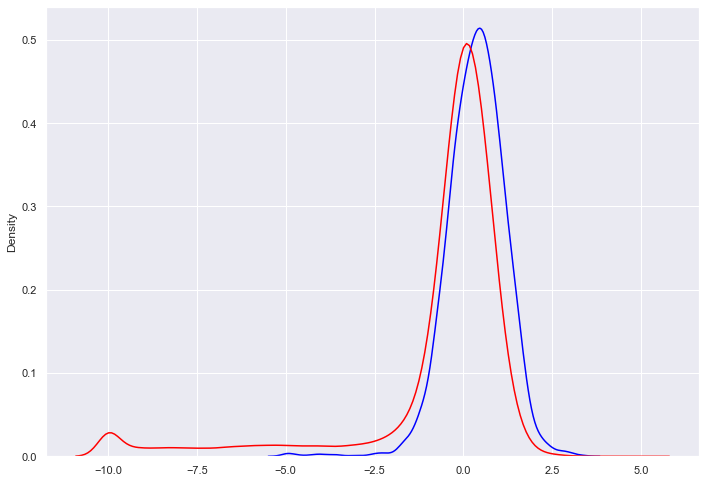

In [391]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(a0,hist=False,color='blue')
sns.distplot(b0,hist=False,color='red')

In [393]:
a0.std()

0.8161588730286418

In [395]:
(np.random.randn(100))

1.0328205398344692

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

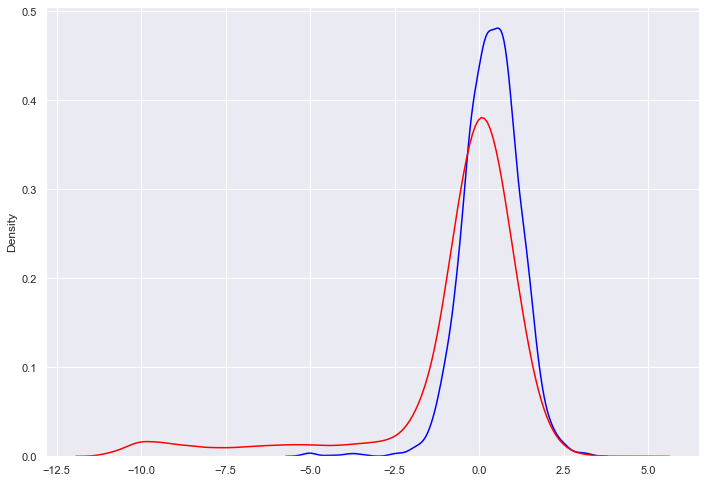

In [401]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(np.clip(a0+np.random.randn(a0.shape[0])*a0.std()/4,-11,5),hist=False,color='blue')
sns.distplot(np.clip(b0+np.random.randn(b0.shape[0])*b0.std()/4,-11,5),hist=False,color='red')

<AxesSubplot:>

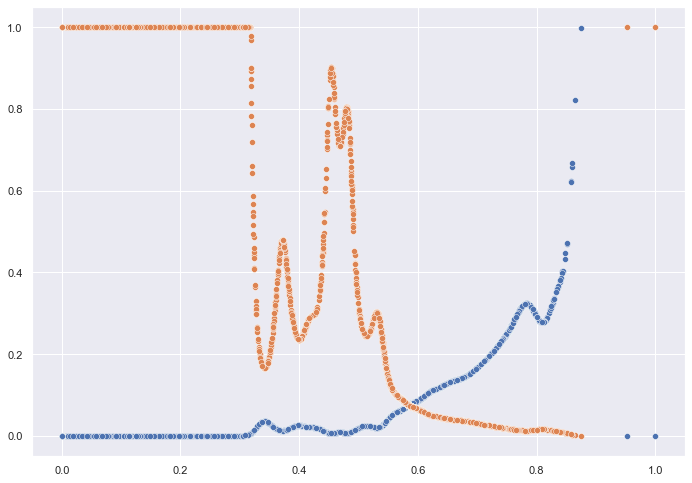

In [57]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=c,y=d)
sns.scatterplot(x=c1,y=d1)

In [58]:
a_mean = a0.mean()
a_std = a0.std()
b_mean = b0.mean()

#As b is not usually normal we use only a std to create range
kde_range = [min(a_mean - 2*a_std, b_mean - 2*a_std),max(a_mean + 2*a_std, b_mean + 2*a_std)]
kde_sample = np.arange(kde_range[0],kde_range[1],(kde_range[1]-kde_range[0])/100)

In [67]:
a_kde_kernel = stats.gaussian_kde(a0)
b_kde_kernel = stats.gaussian_kde(b0)

a_kde_sample = a_kde_kernel.pdf(kde_sample)
b_kde_sample = b_kde_kernel.pdf(kde_sample)
max_ratio = np.abs((b_kde_sample - a_kde_sample)/np.max((a_kde_sample,b_kde_sample),axis=0)).max()

a_kde = a_kde_kernel.pdf(c0)
b_kde = b_kde_kernel.pdf(c0)

c_diff = (b_kde-a_kde)/np.max((a_kde,b_kde),axis=0)
c_diff_clipped = c_diff.clip(0,max=10*max_ratio)
c_diff_log = np.log1p(c_diff_clipped)

<AxesSubplot:>

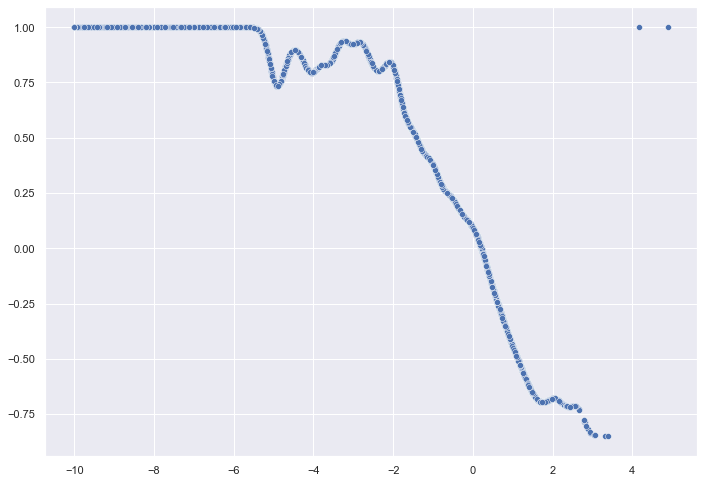

In [71]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=c0,y=c_diff)

In [239]:
c_diff = (b_kde+a_kde)/(a_kde*b_kde)
c_diff_clipped = c_diff.clip(0,max=10*max_ratio)
c_diff_log = np.log1p(c_diff)

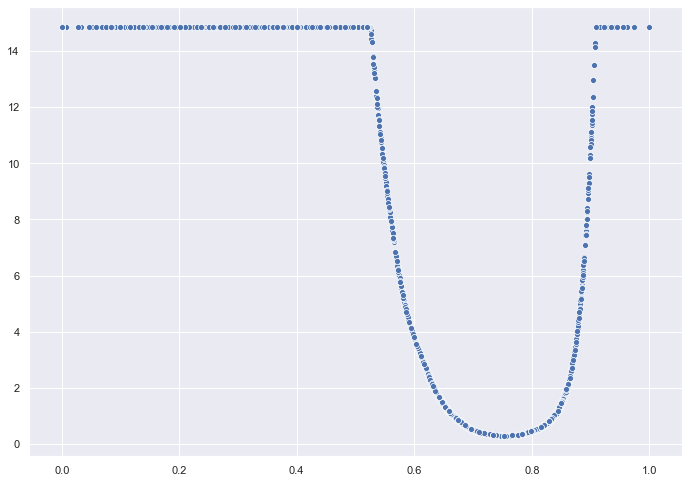

In [240]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=c,y=c_diff_clipped)

In [30]:
def _calculate_kde_kernels(X1,X2):
    X = pd.concat([X1,X2])
    X_control = X[X['cp_type']==1]
    X_treatment = X[X['cp_dose']==0]
    kernels = {}
    cols = ['g-50']
    for col in cols:
        #Calculate kernels
        x_control = X_control[col].values
        x_treatment = X_treatment[col].values
        kde_control_kernel = stats.gaussian_kde(x_control)
        kde_treatment_kernel = stats.gaussian_kde(x_treatment)
        kernels[col+'_control'] = kde_control_kernel
        kernels[col+'_treatment'] = kde_treatment_kernel

        #Calculate max ratio so that when calculating kde features based on the ratio of treatement/control, we have a threshold for values
        x_control_mean = x_control.mean()
        x_control_std = x_control.std()
        x_treatment_mean = x_treatment.mean()
        #As b is not usually normal we use only a std to create range
        kde_range = [min(x_control_mean - 2*x_control_std, x_treatment_mean - 2*x_control_std),max(x_control_mean + 2*x_control_std, x_treatment_mean + 2*x_control_std)]
        kde_sample = np.arange(kde_range[0],kde_range[1],(kde_range[1]-kde_range[0])/100)

        x_control_kde_sample = kde_control_kernel.pdf(kde_sample)
        x_treatment_kde_sample = kde_treatment_kernel.pdf(kde_sample)
        max_ratio = (x_treatment_kde_sample/x_control_kde_sample).max()
        kernels[col+'_ratio'] = max_ratio

    return kernels

In [ ]:
kernels = _calculate_kde_kernels()

# Data augmentation introduction

In [7]:
X_train = prepared_data_normal_kde.X_train.copy()
cols = X_train.columns.tolist()
X_train = X_train.values

In [176]:
rng = np.random.default_rng(seed=42)

granularity = 100 #Means that we granularize the space into 100 distinct values

max_dev = 0.1 #max_dev is the absolute max value we can add or substract from x in the augmented vector
max_dev_steps = int(max_dev*granularity) #max_dev_steps converts max_dev to the number of "steps" to reach max_dev given the granularity

normal_std_dev = 0.1
normal_p = np.arange(-max_dev*granularity,max_dev*granularity+1,1)
normal_p = normal_p/granularity
normal_p = 1/(normal_std_dev)*np.exp(-(normal_p*normal_p)/normal_std_dev**2)
normal_p = normal_p.astype(np.float16)

In [177]:
v_to_augment = np.array([vehicle,vehicle]).transpose()
####
prob_distribution_overall = vehicle_dist.astype(np.float16)
prob_distribution_overall = np.repeat(prob_distribution_overall[np.newaxis,:], v_to_augment.shape[1], axis=0) #p is the probability distribution for each of the columns
###
prob_distribution_overall = np.repeat(prob_distribution_overall[np.newaxis,:], v_to_augment.shape[0], axis=0) #Extend prob_distribution_overall to each dimension
normal_p = np.repeat(normal_p[np.newaxis,:], v_to_augment.shape[1], axis=0)
normal_p = np.repeat(normal_p[np.newaxis,:,:], v_to_augment.shape[0], axis=0)

In [178]:
#Transform v so that it rounds to the desired granularity

v_rounded = (np.round(v_to_augment*granularity)).astype(int)

In [179]:
#For each and every value x in v_rounded, we want to calculate a vector of probability of size 2n+1 such as
#The probability value at index 0 is the probability that we remove max_dev to x

i_steps = np.arange(-max_dev_steps,max_dev_steps+1,1) #initialization vector for the steps
i_initial = np.tile(np.array([[i_steps]]),(v_to_augment.shape[0],v_to_augment.shape[1],1))
v_rounded_repeated = np.repeat(v_rounded[:, :, np.newaxis], i_steps.shape[0], axis=2)
idx = i_initial + v_rounded_repeated
idx = np.clip(idx,0,granularity-1) #For each 

prob_candidates = prob_distribution_overall[0,0,idx].copy()
prob_candidates = prob_candidates*normal_p
prob_candidates = prob_candidates/prob_candidates.sum(axis=2)[:,:,np.newaxis]

In [180]:
%%time
additional = 100
var = np.zeros([v_to_augment.shape[0],v_to_augment.shape[1],additional])
for i in range(v_to_augment.shape[0]):
    for k in range(v_to_augment.shape[1]):
        var[i,k,:] = rng.choice(i_steps,size=additional,p=prob_candidates[i,k,:])
        
var = var/max_dev_steps*max_dev

CPU times: user 1.83 s, sys: 45.2 ms, total: 1.87 s
Wall time: 1.98 s


g-0
0.09250130667618738
0.029706445702359065
0.03758671670647106


<AxesSubplot:ylabel='Density'>

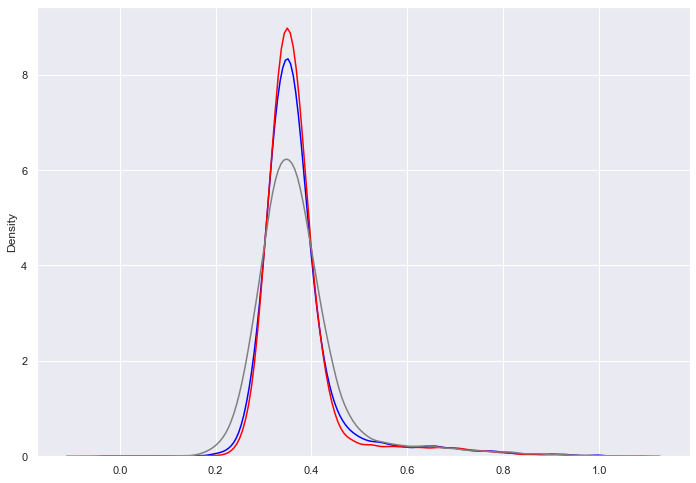

In [181]:
i = 3

exp = cols[i]
print(exp)

vehicle_mask = X_train[:,0]==0
vehicle = X_train[vehicle_mask][:,i]
control = X_train[vehicle_mask==False][:,i]

kernel_control = stats.gaussian_kde(vehicle)
x_for_dist = np.arange(0,1,0.01)
vehicle_dist = kernel_control.pdf(x_for_dist)

vehicle_std = vehicle.std()
var_normal = np.random.randn(vehicle.shape[0])*vehicle_std*0.4

vehicle_augmented = vehicle + var[:,0,0]
print(vehicle_std)
print(np.abs(var_normal).mean())
print(np.abs(var[:,0,0]).mean())

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.kdeplot(vehicle,color='blue')
sns.kdeplot(vehicle_augmented,color='red')
sns.kdeplot(vehicle + var_normal,color='grey')
# sns.lineplot(x_for_dist,vehicle_dist,color='green')
#sns.distplot(control,hist=False,color='grey')

# Remove non differentiating columns

In [22]:
X_train = pd.read_csv(path_data+'train_features.csv')
X_train.drop(['sig_id'],axis=1,inplace=True)
X_train['cp_type'] = X_train['cp_type'].map({'trt_cp':0,'ctl_vehicle':1})
X_train['cp_dose'] = X_train['cp_dose'].map({'D1':0,'D2':1})
X_train['cp_time'] = X_train['cp_time'].map({24:0,48:0.5,72:1})
cols = X_train.columns.tolist()
X_train = X_train.values

g-11
0.008727549118380931


<AxesSubplot:>

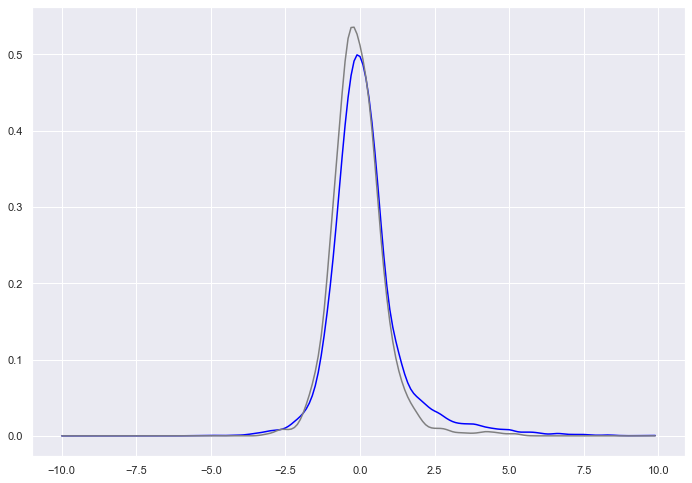

In [107]:
i = 14

exp = cols[i]
print(exp)

vehicle_mask = X_train[:,0]==0
vehicle = X_train[vehicle_mask][:,i]
control = X_train[vehicle_mask==False][:,i]

vehicle_kde = stats.gaussian_kde(vehicle)
control_kde = stats.gaussian_kde(control)

rg = np.arange(-10,10,0.1)
vehicle_kde_sample = vehicle_kde.pdf(rg)
control_kde_sample = control_kde.pdf(rg)

diff = (np.abs(vehicle_kde_sample-control_kde_sample)).mean()
print(diff)


sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.distplot(vehicle,hist=False,color='blue')
# sns.distplot(control,hist=False,color='grey')

sns.lineplot(x=rg,y=vehicle_kde_sample,color='blue')
sns.lineplot(x=rg,y=control_kde_sample,color='grey')

# PCA

In [12]:
all_cols = prepared_data.X_train.columns
g_cols = [x for x in all_cols if ('g-' in x) & (not '_kde_diff' in x)]

In [24]:
X = prepared_data.X_train[g_cols]

In [55]:
pca_g = decomposition.PCA(n_components=X.shape[1],
                          whiten=True,
                          svd_solver='full',
                          random_state=42
                         )

In [56]:
pca_g.fit(X)

PCA(copy=True, iterated_power='auto', n_components=772, random_state=42,
    svd_solver='full', tol=0.0, whiten=True)

In [57]:
a = pca_g.explained_variance_ratio_
a_sum = a.cumsum()

In [58]:
np.argmax(a_sum>0.95),a.shape[0]

(499, 772)

In [59]:
X_pca = pca_g.transform(X)

In [60]:
X_pca[:,0].max()

5.957985143827082

In [ ]:
def _fit_pca(X_list):
    X = pd.concat(X_list,axis=0)
    all_cols = X.columns
    pca_names = ['g','c','g_kde','c_kde']
    g_cols = [x for x in all_cols if ('g-' in x) & (not '_kde_diff' in x)]
    c_cols = [x for x in all_cols if ('c-' in x) & (not '_kde_diff' in x)]
    g_kde_cols = [x for x in all_cols if ('g-' in x) & ('_kde_diff' in x)]
    c_kde_cols = [x for x in all_cols if ('c-' in x) & ('_kde_diff' in x)]
    self.pca_cols_dict = {}
    self.pca_dict = {}
    for name,cols in zip(pca_names,[g_cols,c_cols,g_kde_cols,c_kde_cols]):
        if len(cols)>0:
            X_pca = X[cols]
            pca = decomposition.PCA(n_components=X_pca.shape[1],
                                      whiten=True,
                                      svd_solver='full',
                                      random_state=42
                                     )
            pca.fit(X_pca)
            self.pca_cols_dict[name] = cols
            self.pca_dict[name] = pca

In [ ]:
def _calculate_pca_components_to_keep(self,explained_variance_ratio_,pca_variance_threshold):
    explained_variance_ratio_cum = explained_variance_ratio_.cumsum()
    return np.argmax(explained_variance_ratio_cum>pca_variance_threshold)

def _transform_pca(self,X,pca_variance_threshold):
    pca_names = list(self.pca_cols_dict.keys())
    for name in pca_names:
        #Recover cols and fit pca
        cols = self.pca_cols_dict[name]
        pca = self.pca_dict[name]
        
        #Transform to current data
        X_pca = pca.transform(X[cols])
        
        #Keep only necessary data + transform into pd
        variance_limit = self._calculate_pca_components_to_keep(pca.explained_variance_ratio_,pca_variance_threshold)
        X_pca = X_pca[:,:variance_limit]
        new_cols = [name+'_'+str(i) for i in range(variance_limit)]
        X_pca = pd.DataFrame(X_pca,new_cols)
        
        #Adjust X
        X.drop(cols,axis=1,inplace=True)
        X = pd.concat([X,X_pca],axis=1)
        
    return X

In [61]:
a = {
    'a':1,
    'b':2
}

In [63]:
list(a.keys())

['a', 'b']

# OOF

In [108]:
#%debug
prepared_data = prepareData(path_data,validation_ratio=0.0,folds=5,
                            duplicate_low_label=False,add_kernels=False,
                            perform_pca=True, pca_variance_threshold=0.95
                            )

import data
transform cat features
perform pca
normalize features
create dataset with non scored data
order datasets
remove sig_id


In [110]:
a = prepared_data.X_train.values
b = prepared_data.y_train.values
c = prepared_data.X_train_nonscored.values
vhcl = np.concatenate([a[a[:,0]==0,:][:,3:],b[a[:,0]==0,:],c[a[:,0]==0,:]],axis=1)
oof_assignment = np.zeros(a.shape[0],dtype='int8')

In [369]:
kmeans = cluster.MiniBatchKMeans(n_clusters=3000, n_init=10, verbose=5, batch_size=6, init_size=3000,random_state=42)
#kmeans = cluster.KMeans(n_clusters=3000, n_init=5, verbose=5, max_iter=300, random_state=42, n_jobs=-1)

In [370]:
kmeans.fit(vhcl)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3000, n_init=5, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=5)

In [371]:
vhcl_1 = kmeans.predict(vhcl)
ctrl_1 = kmeans.predict(ctrl)

In [372]:
def naive_oof_assignment(vhcl_1,folds=5):
    folds = np.arange(5)
    folds_count = np.zeros(5)
    unique, counts = np.unique(vhcl_1, return_counts=True)
    r = np.array([unique,counts]).transpose()
    r = r[r[:,1].argsort()]
    oof_idx = np.zeros(vhcl_1.shape[0],dtype='int8')
    for i in r[:,0][::-1]:
        fold_to_fill = np.argmin(folds_count)
        oof_idx[vhcl_1==i] = fold_to_fill
        folds_count[fold_to_fill] += (vhcl_1==i).sum()
    return oof_idx

In [373]:
vhcl_oof = naive_oof_assignment(vhcl_1)
ctrl_oof = naive_oof_assignment(ctrl_1)

oof_assignment[a[:,0]==0] = vhcl_oof
oof_assignment[a[:,0]==1] = ctrl_oof

In [374]:
SHIFT = 2222
oof_assignment_shift = np.roll(oof_assignment,SHIFT)
oof_assignment_pd = pd.DataFrame(oof_assignment_shift,columns=['oof'])
oof_assignment_pd['sig_id'] = prepared_data.X_train_ids.values
oof_assignment_pd.to_csv('data/oof.csv')

In [44]:
r[:,r[1,:]==5]

array([[   9,  109,  288,  354,  517, 2080, 2615, 2733, 2738, 2754, 2756],
       [   5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5]])

In [43]:
r[1,:]==5

array([False, False, False, ..., False, False, False])

In [62]:
a = vhcl[(vhcl_1==2615)]
b = vhcl[(vhcl_1!=2615)]

In [68]:
vhcl_1==2615

array([False, False, False, ..., False, False, False])

In [77]:
b.shape

(17612, 561)

In [78]:
a.std(axis=1).mean(),b[np.random.randint(0,b.shape[0],size=5)].std(axis=1).mean()

(0.10325257645535371, 0.07987622639727607)

<AxesSubplot:>

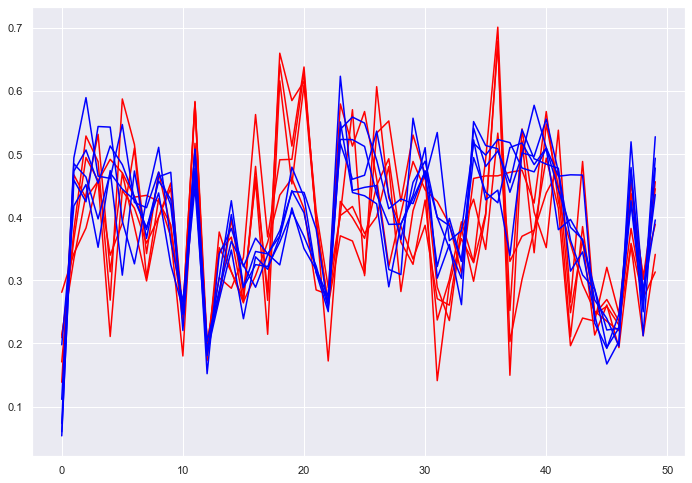

In [79]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
size = 50
sns.lineplot(x=np.arange(0,size),y=a[0,:size],color='red')
sns.lineplot(x=np.arange(0,size),y=a[1,:size],color='red')
sns.lineplot(x=np.arange(0,size),y=a[2,:size],color='red')
sns.lineplot(x=np.arange(0,size),y=a[3,:size],color='red')
sns.lineplot(x=np.arange(0,size),y=a[4,:size],color='red')

sns.lineplot(x=np.arange(0,size),y=b[0,:size],color='blue')
sns.lineplot(x=np.arange(0,size),y=b[1,:size],color='blue')
sns.lineplot(x=np.arange(0,size),y=b[2,:size],color='blue')
sns.lineplot(x=np.arange(0,size),y=b[3,:size],color='blue')
sns.lineplot(x=np.arange(0,size),y=b[4,:size],color='blue')

# Post processing - antagonist MoA

In [94]:
y1 = pd.read_csv(path_data+'train_targets_scored.csv')
y2 = pd.read_csv(path_data+'train_targets_nonscored.csv')
y = pd.DataFrame(np.concatenate([y1.values,y2.values],axis=1),columns=y1.columns.tolist()+y2.columns.tolist())

In [122]:
y_cols = y.columns
effect = [x.split('_')[-1] for x in y_cols[1:]]
names = ['_'.join(x.split('_')[:-1]) for x in y_cols[1:]]

In [ ]:
antagonist_pairs = []

In [151]:
names_pd = pd.DataFrame(y_cols[1:],columns=['initial'])
names_pd['after'] = names

In [152]:
names_pd = names_pd.groupby(['after'],as_index=False).agg(
    {'initial':[list,'count']}
)

In [282]:
names_pd[names_pd['initial']['count']==2]['initial']['list'].tolist()

[['acetylcholine_receptor_agonist', 'acetylcholine_receptor_antagonist'],
 ['adenosine_receptor_agonist', 'adenosine_receptor_antagonist'],
 ['adenylyl_cyclase_activator', 'adenylyl_cyclase_inhibitor'],
 ['adrenergic_receptor_agonist', 'adrenergic_receptor_antagonist'],
 ['aldehyde_dehydrogenase_inhibitor', 'aldehyde_dehydrogenase_activator'],
 ['ampk_activator', 'ampk_inhibitor'],
 ['androgen_receptor_agonist', 'androgen_receptor_antagonist'],
 ['angiotensin_receptor_antagonist', 'angiotensin_receptor_agonist'],
 ['apoptosis_stimulant', 'apoptosis_inhibitor'],
 ['aryl_hydrocarbon_receptor_agonist', 'aryl_hydrocarbon_receptor_antagonist'],
 ['atp_channel_activator', 'atp_channel_blocker'],
 ['benzodiazepine_receptor_agonist', 'benzodiazepine_receptor_antagonist'],
 ['calcium_channel_blocker', 'calcium_channel_activator'],
 ['cannabinoid_receptor_agonist', 'cannabinoid_receptor_antagonist'],
 ['car_agonist', 'car_antagonist'],
 ['caspase_activator', 'caspase_inhibitor'],
 ['cc_chemokine

In [265]:
pd.options.display.max_rows = 999
y[y['membrane_permeability_inhibitor']==1]\
[['membrane_permeability_enhancer', 'membrane_permeability_inhibitor']]

,membrane_permeability_enhancer,membrane_permeability_inhibitor
656,0,1
5245,0,1
6666,0,1
7820,0,1
9266,0,1
11303,0,1
11731,0,1
14247,0,1
15400,0,1
18371,0,1


In [283]:
exclusivity_tuples = [
 ['potassium_channel_activator',
  'potassium_channel_antagonist',
  'potassium_channel_agonist',
  'potassium_channel_blocker'],
 ['atp-sensitive_potassium_channel_antagonist',
  'atp-sensitive_potassium_channel_agonist',
  'atp-sensitive_potassium_channel_inhibitor'],
 ['gaba_receptor_agonist',
  'gaba_receptor_modulator'],
 ['glutamate_receptor_agonist',
  'glutamate_receptor_antagonist',
  'glutamate_receptor_modulator'],
 ['nitric_oxide_donor',
  'nitric_oxide_scavenger',
  'nitric_oxide_stimulant'],
 ['prostanoid_receptor_antagonist',
  'prostanoid_receptor_agonist',
 ' prostanoid_receptor_inhibitor'],
 ['sodium_channel_inhibitor',
  'sodium_channel_activator',
  'sodium_channel_blocker'],
 ['acetylcholine_receptor_agonist',
  'acetylcholine_receptor_antagonist'],
 ['adenosine_receptor_agonist',
  'adenosine_receptor_antagonist'],
 ['adenylyl_cyclase_activator',
  'adenylyl_cyclase_inhibitor'],
 ['adrenergic_receptor_agonist',
  'adrenergic_receptor_antagonist'],
 ['aldehyde_dehydrogenase_inhibitor',
  'aldehyde_dehydrogenase_activator'],
 ['ampk_activator',
  'ampk_inhibitor'],
 ['androgen_receptor_agonist',
  'androgen_receptor_antagonist'],
 ['angiotensin_receptor_antagonist',
  'angiotensin_receptor_agonist'],
 ['apoptosis_stimulant', 
  'apoptosis_inhibitor'],
 ['aryl_hydrocarbon_receptor_agonist', 
  'aryl_hydrocarbon_receptor_antagonist'],
 ['atp_channel_activator', 
  'atp_channel_blocker'],
 ['benzodiazepine_receptor_agonist', 
  'benzodiazepine_receptor_antagonist'],
 ['calcium_channel_blocker',
  'calcium_channel_activator'],
 ['cannabinoid_receptor_agonist', 
  'cannabinoid_receptor_antagonist'],
 ['car_agonist', 
  'car_antagonist'],
 ['caspase_activator', 
  'caspase_inhibitor'],
 ['cc_chemokine_receptor_antagonist',
  'cc_chemokine_receptor_agonist'],
 ['cftr_channel_agonist', 
  'cftr_channel_antagonist'],
 ['chloride_channel_blocker',
  'chloride_channel_activator'],
 ['cholinergic_receptor_antagonist',
  'cholinergic_receptor_agonist'],
 ['complement_antagonist', 
  'complement_inhibitor'],
 ['corticosteroid_agonist',
  'corticosteroid_antagonist'],
 ['dopamine_receptor_agonist',
  'dopamine_receptor_antagonist'],
 ['estrogen_receptor_agonist',
  'estrogen_receptor_antagonist'],
 ['fatty_acid_receptor_agonist',
  'fatty_acid_receptor_antagonist'],
 ['fxr_agonist', 
  'fxr_antagonist'],
 ['g_protein-coupled_receptor_agonist',
  'g_protein-coupled_receptor_antagonist'],
 ['glucocorticoid_receptor_agonist',
  'glucocorticoid_receptor_antagonist'],
 ['glucokinase_activator',
  'glucokinase_inhibitor'],
 ['gonadotropin_receptor_agonist',
  'gonadotropin_receptor_antagonist'],
 ['guanylate_cyclase_activator',
  'guanylate_cyclase_stimulant'],
 ['histamine_receptor_agonist',
  'histamine_receptor_antagonist'],
 ['hsp_inhibitor',
  'hsp_inducer'],
 ['icam1_antagonist',
  'icam1_inhibitor'],
 ['membrane_permeability_enhancer',
  'membrane_permeability_inhibitor'],
 ['mineralocorticoid_receptor_antagonist',
  'mineralocorticoid_receptor_agonist'],
 ['neurotensin_receptor_agonist',
  'neurotensin_receptor_antagonist'],
 ['nfkb_inhibitor', 
  'nfkb_activator'],
 ['opioid_receptor_agonist',
  'opioid_receptor_antagonist'],
 ['oxytocin_receptor_agonist',
  'oxytocin_receptor_antagonist'],
 ['p53_activator',
  'p53_inhibitor'],
 ['phospholipase_inhibitor',
  'phospholipase_activator'],
 ['pka_activator',
  'pka_inhibitor'],
 ['ppar_receptor_agonist',
  'ppar_receptor_antagonist'],
 ['progesterone_receptor_agonist',
  'progesterone_receptor_antagonist'],
 ['protein_kinase_inhibitor', 
  'protein_kinase_activator'],
 ['protein_synthesis_inhibitor',
  'protein_synthesis_stimulant'],
 ['retinoid_receptor_agonist', 
  'retinoid_receptor_antagonist'],
 ['serotonin_receptor_agonist', 
  'serotonin_receptor_antagonist'],
 ['sigma_receptor_agonist', 
  'sigma_receptor_antagonist'],
 ['sirt_activator',
  'sirt_inhibitor'],
 ['smoothened_receptor_antagonist',
  'smoothened_receptor_agonist'],
 ['src_inhibitor',
  'src_activator'],
 ['thyroid_hormone_inhibitor',
  'thyroid_hormone_stimulant'],
 ['tlr_agonist',
  'tlr_antagonist'],
 ['trace_amine_associated_receptor_agonist',
  'trace_amine_associated_receptor_antagonist'],
 ['transient_receptor_potential_channel_antagonist',
  'transient_receptor_potential_channel_agonist'],
 ['trpv_agonist',
  'trpv_antagonist'],
 ['urotensin_receptor_agonist',
  'urotensin_receptor_antagonist'],
 ['vasopressin_receptor_agonist',
  'vasopressin_receptor_antagonist'],
 ['wnt_inhibitor',
  'wnt_agonist']
]